# Modelling
This notebook is where I have performed all my modelling tasks and hyperparameter tuning.

In [70]:
## all necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import mlflow
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, models
import optuna
import pickle

from optuna.integration import LightGBMPruningCallback
import warnings
warnings.filterwarnings("ignore")

mlflow.set_experiment("credit_score")
mlflow.sklearn.autolog()
mlflow.tensorflow.autolog()

2021/12/06 15:34:11 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


In [71]:
df = pd.read_csv('../data/cleaned/train.csv', index_col=0)
df.head()

,company_id,has_payment_note,payment_note_amount,years_data,revenue,revenue-1,revenue-2,revenue-3,revenue-4,net_sales,...,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4,Rating
0,1,1,6487.0,5,5677,8673.0,8532.0,7825.0,5385.0,5677,...,13.6,10.3,16.8,-5.4,395.5,232.4,184.7,236.4,148.1,AAA
1,2,0,0.0,5,10617,8266.0,9713.0,9428.0,7394.0,10506,...,9.1,15.9,23.1,16.8,229.0,280.7,296.1,234.0,213.0,AA
2,3,0,0.0,1,7201,0.0,0.0,0.0,0.0,7201,...,0.0,0.0,0.0,0.0,128.1,0.0,0.0,0.0,0.0,AA
3,4,0,0.0,5,22629,20668.0,24591.0,23754.0,23656.0,22619,...,0.2,2.9,0.1,1.9,97.8,89.2,82.2,72.4,92.9,A
4,5,1,85539.0,5,10221,8358.0,5865.0,4038.0,5128.0,10216,...,14.6,-0.4,-0.6,9.7,159.9,183.1,112.5,215.5,134.3,AA


In [72]:
## endcode the 5 training labels
le = LabelEncoder()
le.fit_transform(df['Rating'])
np.save('../models/classes.npy', le.classes_)
le.classes_

array(['A', 'AA', 'AAA', 'B', 'C'], dtype=object)

In [73]:
encoded_labels = le.transform(df['Rating'])

In [74]:
encoded_labels

array([2, 1, 1, ..., 1, 1, 1])

In [75]:
# test undoing the encoding
le.inverse_transform(encoded_labels)

array(['AAA', 'AA', 'AA', ..., 'AA', 'AA', 'AA'], dtype=object)

In [130]:
df['Rating'] = encoded_labels
df.drop('company_id', axis=1, inplace=True)
df.head()

,has_payment_note,payment_note_amount,years_data,revenue,revenue-1,revenue-2,revenue-3,revenue-4,net_sales,net_sales-1,...,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4,Rating
0,1,6487.0,5,5677,8673.0,8532.0,7825.0,5385.0,5677,8663.0,...,13.6,10.3,16.8,-5.4,395.5,232.4,184.7,236.4,148.1,2
1,0,0.0,5,10617,8266.0,9713.0,9428.0,7394.0,10506,8254.0,...,9.1,15.9,23.1,16.8,229.0,280.7,296.1,234.0,213.0,1
2,0,0.0,1,7201,0.0,0.0,0.0,0.0,7201,0.0,...,0.0,0.0,0.0,0.0,128.1,0.0,0.0,0.0,0.0,1
3,0,0.0,5,22629,20668.0,24591.0,23754.0,23656.0,22619,20667.0,...,0.2,2.9,0.1,1.9,97.8,89.2,82.2,72.4,92.9,0
4,1,85539.0,5,10221,8358.0,5865.0,4038.0,5128.0,10216,8358.0,...,14.6,-0.4,-0.6,9.7,159.9,183.1,112.5,215.5,134.3,1


In [144]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [145]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

## Rapid Model Testing

In [79]:
#rapidly test a group of models with 3 fold cross validation
dfs = []
models = [
    ('SVC', SVC()), 
    ('DT', DecisionTreeClassifier()),
    ('LOG', LogisticRegression()),
    ('LGBM', lgbm.LGBMClassifier())]
results = []
names = []
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for name, model in models:
    skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    with mlflow.start_run() as run:
        cv_results = cross_validate(model, X_train, y_train, cv=skfolds, scoring=scoring)
    results.append(cv_results)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred))
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)

2021/12/06 15:34:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '79c210b3d12b4adb80df263beaa9c6de', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2021/12/06 15:34:49 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [Errno 30] Read-only file system: '/mnt'


SVC
              precision    recall  f1-score   support

           0       0.31      0.01      0.03       648
           1       0.46      0.93      0.61      1318
           2       0.74      0.38      0.51       845
           3       0.50      0.00      0.01       299
           4       0.51      0.41      0.46       180

    accuracy                           0.50      3290
   macro avg       0.50      0.35      0.32      3290
weighted avg       0.51      0.50      0.41      3290



2021/12/06 15:34:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'afee5d221c86475c85a280c48e67e81f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2021/12/06 15:34:55 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [Errno 30] Read-only file system: '/mnt'


DT
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       648
           1       0.66      0.69      0.68      1318
           2       0.68      0.65      0.67       845
           3       0.59      0.53      0.56       299
           4       0.63      0.64      0.64       180

    accuracy                           0.65      3290
   macro avg       0.63      0.62      0.63      3290
weighted avg       0.65      0.65      0.65      3290



2021/12/06 15:34:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '86202488c29445d7b1c69fd86369318f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2021/12/06 15:34:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [Errno 30] Read-only file system: '/mnt'


LOG
              precision    recall  f1-score   support

           0       0.49      0.40      0.44       648
           1       0.57      0.78      0.66      1318
           2       0.65      0.53      0.59       845
           3       0.66      0.27      0.39       299
           4       0.69      0.53      0.60       180

    accuracy                           0.58      3290
   macro avg       0.61      0.50      0.53      3290
weighted avg       0.59      0.58      0.57      3290

LGBM
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       648
           1       0.75      0.82      0.78      1318
           2       0.79      0.77      0.78       845
           3       0.77      0.62      0.69       299
           4       0.81      0.71      0.76       180

    accuracy                           0.76      3290
   macro avg       0.77      0.72      0.74      3290
weighted avg       0.76      0.76      0.76      3290



In [80]:
# compare mean results across the three folds
final = final.groupby('model').mean().sort_values(by='test_accuracy', ascending = False)
final

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro
model,,,,,,
LGBM,2.127338,0.036013,0.745765,0.746466,0.694849,0.717059
DT,0.309155,0.009129,0.642168,0.607341,0.604957,0.605851
LOG,0.318079,0.012320,0.577925,0.566147,0.454487,0.484343
SVC,1.961555,2.165289,0.505343,0.373216,0.323239,0.301150


In [187]:
print(final.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  fit\_time &  score\_time &  test\_accuracy &  test\_precision\_macro &  test\_recall\_macro &  test\_f1\_macro \\
model &           &             &                &                       &                    &                \\
\midrule
LGBM  &  2.127338 &    0.036013 &       0.745765 &              0.746466 &           0.694849 &       0.717059 \\
DT    &  0.309155 &    0.009129 &       0.642168 &              0.607341 &           0.604957 &       0.605851 \\
LOG   &  0.318079 &    0.012320 &       0.577925 &              0.566147 &           0.454487 &       0.484343 \\
SVC   &  1.961555 &    2.165289 &       0.505343 &              0.373216 &           0.323239 &       0.301150 \\
\bottomrule
\end{tabular}



KeyboardInterrupt: 

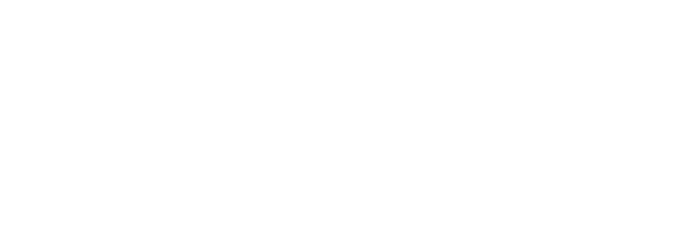

In [186]:
fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=final.values,colLabels=final.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
#pp = PdfPages("foo.pdf")
#pp.savefig(fig, bbox_inches='tight')
#pp.close()

## LightGBM Model

In [146]:
# setup a lightgbm model
clf = lgbm.LGBMClassifier()
clf.fit(X_train, y_train)

LGBMClassifier()

In [147]:
y_pred = clf.predict(X_test)

In [148]:
accuracy = accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.7544


In [149]:
y_pred_train = clf.predict(X_train)

In [150]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9878
Test set score: 0.7544


In [151]:
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[ 456  142   15   28    7]
 [  76 1079  150    9    4]
 [   7  186  651    1    0]
 [  67   25    3  185   19]
 [  26    8    1   17  128]]


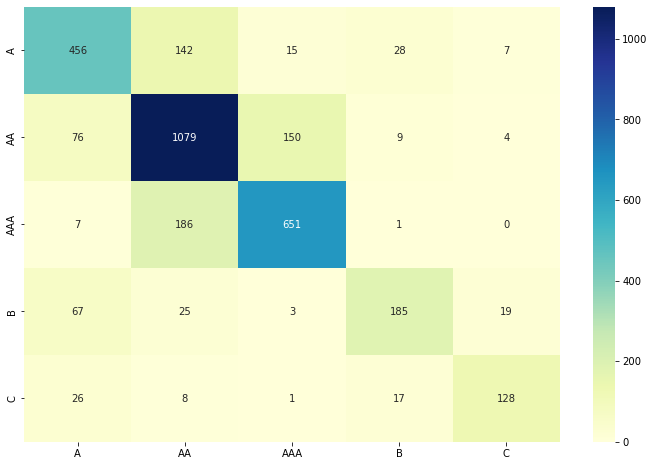

In [152]:
# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.savefig('../images/confusion_matrix.png', facecolor='w')
plt.show()

In [88]:
## these are good metrics on the test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       648
           1       0.75      0.82      0.78      1318
           2       0.79      0.77      0.78       845
           3       0.77      0.62      0.69       299
           4       0.81      0.71      0.76       180

    accuracy                           0.76      3290
   macro avg       0.77      0.72      0.74      3290
weighted avg       0.76      0.76      0.76      3290



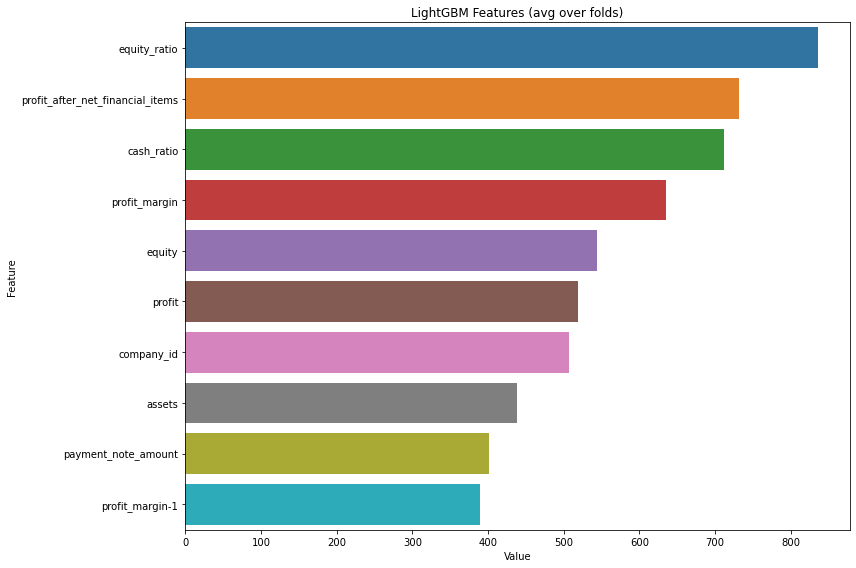

In [89]:
## get feature importances
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(12, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:10])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('../images/lgbm_importances.png', facecolor='w')
plt.show()


## HyperParameter Tuning

In [90]:
## setup objective grid for tuning
def objective(trial, X, y):
    param_grid = {
        #"boosting_type": trial.suggest_categorical("boosting_type", ["dart"]),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="multiclass", class_weight='balanced', **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, metric="multi_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [91]:
#perform hyperameter tuning
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2021-12-06 15:35:10,496] A new study created in memory with name: LGBM Classifier


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.68455152096629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.68455152096629
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2021-12-06 15:35:11,274] Trial 0 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21764491652150908, 'num_leaves': 700, 'max_depth': 8, 'min_data_in_leaf': 8600, 'lambda_l1': 20, 'lambda_l2': 35, 'min_gain_to_split': 13.68455152096629, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8600
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=13.68455152096629, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13.68455152096629
[LightGBM] [Warning] lambda_l1 is set=20, reg_alpha=0.0 will be ignored. Current value: lambda_l1=20
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in

[I 2021-12-06 15:35:11,938] Trial 1 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.15621191342684412, 'num_leaves': 1440, 'max_depth': 10, 'min_data_in_leaf': 8000, 'lambda_l1': 5, 'lambda_l2': 40, 'min_gain_to_split': 14.604745970361854, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.633426855067295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.633426855067295
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_s

[I 2021-12-06 15:35:12,597] Trial 2 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.06470731046892043, 'num_leaves': 980, 'max_depth': 12, 'min_data_in_leaf': 9300, 'lambda_l1': 65, 'lambda_l2': 60, 'min_gain_to_split': 4.633426855067295, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9300
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.633426855067295, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.633426855067295
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4700, min_child_s

[I 2021-12-06 15:35:13,281] Trial 3 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16518902805236982, 'num_leaves': 660, 'max_depth': 12, 'min_data_in_leaf': 4700, 'lambda_l1': 95, 'lambda_l2': 45, 'min_gain_to_split': 9.293082483958717, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=6.585777363287365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.585777363287365
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2021-12-06 15:35:13,983] Trial 4 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.04201080585437659, 'num_leaves': 1020, 'max_depth': 5, 'min_data_in_leaf': 10000, 'lambda_l1': 65, 'lambda_l2': 5, 'min_gain_to_split': 6.585777363287365, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=10000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10000
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=6.585777363287365, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6.585777363287365
[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2021-12-06 15:35:15,149] Trial 5 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.1051054125581836, 'num_leaves': 960, 'max_depth': 8, 'min_data_in_leaf': 2700, 'lambda_l1': 90, 'lambda_l2': 30, 'min_gain_to_split': 0.9550303701289281, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.6000000000000001}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.2625809041177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.2625809041177
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Lig

[I 2021-12-06 15:35:15,807] Trial 6 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2506222837477955, 'num_leaves': 640, 'max_depth': 8, 'min_data_in_leaf': 9400, 'lambda_l1': 55, 'lambda_l2': 50, 'min_gain_to_split': 8.2625809041177, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9400
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=8.2625809041177, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.2625809041177
[LightGBM] [Warning] lambda_l1 is set=55, reg_alpha=0.0 will be ignored. Current value: lambda_l1=55
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[Lig

[I 2021-12-06 15:35:16,477] Trial 7 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21923124481529715, 'num_leaves': 2340, 'max_depth': 9, 'min_data_in_leaf': 6700, 'lambda_l1': 30, 'lambda_l2': 55, 'min_gain_to_split': 9.727260255007703, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=5.043400963461695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.043400963461695
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2021-12-06 15:35:17,132] Trial 8 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.16179953214806123, 'num_leaves': 1700, 'max_depth': 10, 'min_data_in_leaf': 8800, 'lambda_l1': 45, 'lambda_l2': 25, 'min_gain_to_split': 5.043400963461695, 'bagging_fraction': 0.30000000000000004, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=8800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8800
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.30000000000000004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.30000000000000004
[LightGBM] [Warning] min_gain_to_split is set=5.043400963461695, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.043400963461695
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2021-12-06 15:35:17,835] Trial 9 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.293301936909354, 'num_leaves': 1960, 'max_depth': 7, 'min_data_in_leaf': 7000, 'lambda_l1': 75, 'lambda_l2': 5, 'min_gain_to_split': 12.626877221440285, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 0 with value: 1.609437911221773.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=11.732523983335843, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11.732523983335843
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samp

[I 2021-12-06 15:35:25,319] Trial 10 finished with value: 0.8034751177106747 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21747632618002263, 'num_leaves': 40, 'max_depth': 3, 'min_data_in_leaf': 700, 'lambda_l1': 5, 'lambda_l2': 90, 'min_gain_to_split': 11.732523983335843, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 10 with value: 0.8034751177106747.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=12.556571048383471, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.556571048383471
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_sa

[I 2021-12-06 15:35:31,533] Trial 11 finished with value: 0.7892092976255196 and parameters: {'n_estimators': 10000, 'learning_rate': 0.21523203809422106, 'num_leaves': 60, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 0, 'lambda_l2': 100, 'min_gain_to_split': 12.556571048383471, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 11 with value: 0.7892092976255196.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=12.005928419504684, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.005928419504684
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samp

[I 2021-12-06 15:35:36,406] Trial 12 finished with value: 0.7852675308651872 and parameters: {'n_estimators': 10000, 'learning_rate': 0.210011004747083, 'num_leaves': 80, 'max_depth': 3, 'min_data_in_leaf': 300, 'lambda_l1': 0, 'lambda_l2': 95, 'min_gain_to_split': 12.005928419504684, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 12 with value: 0.7852675308651872.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.917015131216004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.917015131216004
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_sa

[I 2021-12-06 15:35:39,284] Trial 13 finished with value: 0.7815119561815064 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2766527802522418, 'num_leaves': 140, 'max_depth': 3, 'min_data_in_leaf': 200, 'lambda_l1': 0, 'lambda_l2': 100, 'min_gain_to_split': 10.917015131216004, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=10.987895092323296, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.987895092323296
[LightGBM] [Warning] lambda_l1 is set=25, reg_alpha=0.0 will be ignored. Current value: lambda_l1=25
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child

[I 2021-12-06 15:35:42,449] Trial 14 finished with value: 0.9450496687163978 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2993169740561784, 'num_leaves': 2740, 'max_depth': 5, 'min_data_in_leaf': 2000, 'lambda_l1': 25, 'lambda_l2': 80, 'min_gain_to_split': 10.987895092323296, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.30909767936993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.30909767936993
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_s

[I 2021-12-06 15:35:43,137] Trial 15 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2573906444588714, 'num_leaves': 260, 'max_depth': 5, 'min_data_in_leaf': 3900, 'lambda_l1': 15, 'lambda_l2': 75, 'min_gain_to_split': 10.30909767936993, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3900
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=10.30909767936993, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.30909767936993
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_s

[I 2021-12-06 15:35:47,869] Trial 16 finished with value: 0.9367558826695058 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11469663494381871, 'num_leaves': 400, 'max_depth': 4, 'min_data_in_leaf': 1600, 'lambda_l1': 40, 'lambda_l2': 100, 'min_gain_to_split': 7.387850913134156, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=14.635333717939144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.635333717939144
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child

[I 2021-12-06 15:35:48,624] Trial 17 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.2646352209221736, 'num_leaves': 1380, 'max_depth': 6, 'min_data_in_leaf': 3400, 'lambda_l1': 15, 'lambda_l2': 75, 'min_gain_to_split': 14.635333717939144, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=3400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3400
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=14.635333717939144, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14.635333717939144
[LightGBM] [Warning] lambda_l1 is set=15, reg_alpha=0.0 will be ignored. Current value: lambda_l1=15
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1300, min_child

[I 2021-12-06 15:35:53,418] Trial 18 finished with value: 0.8755070566020764 and parameters: {'n_estimators': 10000, 'learning_rate': 0.18600228518912734, 'num_leaves': 360, 'max_depth': 3, 'min_data_in_leaf': 1300, 'lambda_l1': 35, 'lambda_l2': 85, 'min_gain_to_split': 0.3187671992392609, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.699512534175337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.699512534175337
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_sam

[I 2021-12-06 15:35:54,376] Trial 19 finished with value: 1.609437911221773 and parameters: {'n_estimators': 10000, 'learning_rate': 0.11920994950442164, 'num_leaves': 1200, 'max_depth': 4, 'min_data_in_leaf': 5700, 'lambda_l1': 0, 'lambda_l2': 65, 'min_gain_to_split': 8.699512534175337, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 13 with value: 0.7815119561815064.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=5700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5700
[LightGBM] [Warning] lambda_l2 is set=65, reg_lambda=0.0 will be ignored. Current value: lambda_l2=65
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=8.699512534175337, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8.699512534175337
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


In [92]:
# print best parameters
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 0.78151
	Best params:
		n_estimators: 10000
		learning_rate: 0.2766527802522418
		num_leaves: 140
		max_depth: 3
		min_data_in_leaf: 200
		lambda_l1: 0
		lambda_l2: 100
		min_gain_to_split: 10.917015131216004
		bagging_fraction: 0.9
		bagging_freq: 1
		feature_fraction: 0.4


In [93]:
params = study.best_params

In [94]:
# create a classifer with tuned values
tuned_clf = lgbm.LGBMClassifier(objective="multiclass", class_weight='balanced', **params)
tuned_clf.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] min_gain_to_split is set=10.917015131216004, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.917015131216004
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0


LGBMClassifier(bagging_fraction=0.9, bagging_freq=1, class_weight='balanced',
               feature_fraction=0.4, lambda_l1=0, lambda_l2=100,
               learning_rate=0.2766527802522418, max_depth=3,
               min_data_in_leaf=200, min_gain_to_split=10.917015131216004,
               n_estimators=10000, num_leaves=140, objective='multiclass')

In [95]:
y_pred = tuned_clf.predict(X_test)

In [96]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6872


## Tensorflow Model

In [97]:
#build tensorflow nn classifier
model = tf.keras.Sequential([
    tf.keras.layers.Dense(54, activation='relu', input_shape=(54,)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
model

2021-12-06 15:36:11.253277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [98]:
# compile model
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [99]:
# fit the model
model.fit(X_train, y_train, batch_size=50, epochs=100)

2021/12/06 15:36:11 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd0ccf70b194240b8a1be23e64bb48466', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2021-12-06 15:36:11.502824: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-06 15:36:11.502849: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-06 15:36:11.504497: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-06 15:36:11.743666: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
104/154 [===================>..........] - ETA: 0s - loss: 851.7274 - accuracy: 0.2394 

2021-12-06 15:36:12.563723: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-12-06 15:36:12.563741: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-12-06 15:36:12.570300: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-12-06 15:36:12.581698: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-12-06 15:36:12.610796: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: /var/folders/2f/rkv3v49j0b7_2hx0f3fxytf09v2bcg/T/tmpvhrm851i/train/plugins/profile/2021_12_06_15_36_12
2021-12-06 15:36:12.612622: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to /var/folders/2f/rkv3v49j0b7_2hx0f3fxytf09v2bcg/T/tmpvhrm851i/train/plugins/profile/2021_12_06_15_36_12/Chris-MBPro.local.trace.json.gz
2021-12-06 15:36:12.639976: I tensorflow/core/profiler/rpc/client/sa

154/154 [==============================] - 1s 2ms/step - loss: 631.2017 - accuracy: 0.2793
Epoch 2/100
154/154 [==============================] - 0s 961us/step - loss: 1.5575 - accuracy: 0.4306
Epoch 3/100
154/154 [==============================] - 0s 883us/step - loss: 1.4757 - accuracy: 0.4229
Epoch 4/100
154/154 [==============================] - 0s 685us/step - loss: 1.4271 - accuracy: 0.4384
Epoch 5/100
154/154 [==============================] - 0s 676us/step - loss: 1.4063 - accuracy: 0.4301
Epoch 6/100
154/154 [==============================] - 0s 671us/step - loss: 1.4109 - accuracy: 0.4360
Epoch 7/100
154/154 [==============================] - 0s 677us/step - loss: 1.3804 - accuracy: 0.4321
Epoch 8/100
154/154 [==============================] - 0s 671us/step - loss: 1.3795 - accuracy: 0.4290
Epoch 9/100
154/154 [==============================] - 0s 684us/step - loss: 1.3802 - accuracy: 0.4264
Epoch 10/100
154/154 [==============================] - 0s 695us/step - loss: 1.3604 

2021-12-06 15:36:23.800439: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/2f/rkv3v49j0b7_2hx0f3fxytf09v2bcg/T/tmpei8zxc6b/model/data/model/assets


In [100]:
# sad face for bad performance
model.evaluate(X_test, y_test)

103/103 [==============================] - 0s 490us/step - loss: 2.3683 - accuracy: 0.4000


[2.368317127227783, 0.4000000059604645]

## SHAP

In [102]:
# use shap analysis to inspect features
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

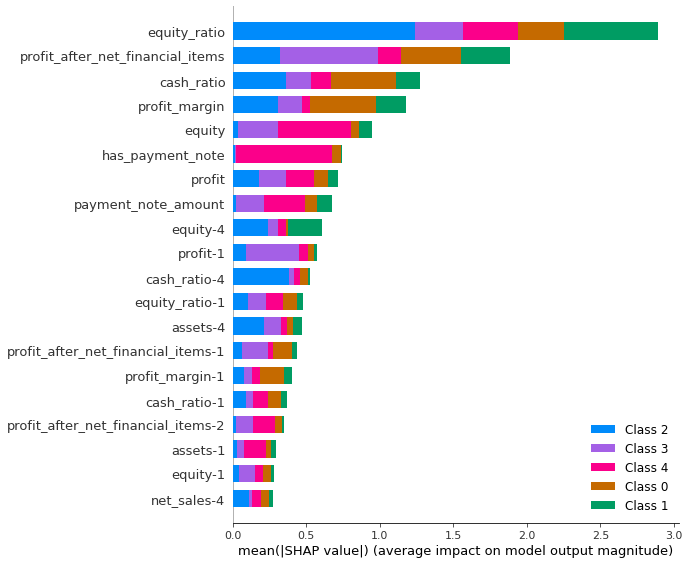

In [103]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, show=False)
plt.savefig('../images/shap_values.png', facecolor='w', bbox_inches='tight')
plt.show()

In [153]:
## saving the model
filename = '../models/best_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(clf, file)

In [154]:
#load the model
with open('../models/best_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [168]:
test_df = pd.read_csv('../data/raw/test.csv')
test_df

,company_id,payment_note_date,payment_note_amount,financials_date,financials_date-1,financials_date-2,financials_date-3,financials_date-4,revenue,revenue-1,...,profit_margin,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4
0,10965,NaN,NaN,Dec-17,Dec-16,Dec-15,Dec-14,NaN,4617,3760.0,...,23.1,9.5,-0.3,5.1,NaN,48.0,112.9,74.9,46.7,NaN
1,10966,NaN,NaN,Dec-17,Dec-16,Dec-15,Dec-14,Dec-13,5446,5529.0,...,1.7,0.8,0.3,0.6,-1.3,30.2,35.2,44.9,48.6,39.7
2,10967,NaN,NaN,Apr-18,Apr-17,Apr-16,Apr-15,Apr-14,8087,6872.0,...,20.0,11.3,15.9,21.8,13.4,273.9,239.3,296.9,631.8,568.1
3,10968,NaN,NaN,Dec-17,Dec-16,Dec-15,Dec-14,Dec-13,9507,7449.0,...,25.9,23.1,11.7,5.8,12.5,115.6,89.9,102.5,80.8,86.2
4,10969,NaN,0.0,Jun-18,Jun-17,Jun-16,Jun-15,Jun-14,45618,48085.0,...,13.2,9.8,18.0,10.5,14.6,190.2,181.1,186.9,151.6,158.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,13701,NaN,0.0,Dec-17,Dec-16,Dec-15,Dec-14,Dec-13,23235,20661.0,...,2.3,1.6,5.1,-9.4,-8.5,163.9,174.0,155.6,114.6,183.6
2737,13702,NaN,0.0,Apr-18,Apr-17,Apr-16,Apr-15,Apr-14,18259,14507.0,...,11.9,2.2,5.0,2.0,0.6,165.2,152.8,124.1,110.2,87.2
2738,13703,NaN,NaN,Aug-18,Aug-17,Aug-16,Aug-15,Aug-14,14527,9733.0,...,0.8,3.7,4.6,1.4,1.9,153.7,151.0,122.4,91.1,115.3
2739,13704,NaN,NaN,Aug-17,Aug-16,Aug-15,Aug-14,Aug-13,5657,4861.0,...,14.3,12.2,15.9,12.0,10.1,291.7,286.6,244.7,176.9,81.2


In [169]:
## do al cleaning and transformations before prediction
def cleaning(data):
    for i in range(3, 8):
        data.iloc[:, i] = pd.to_datetime(data.iloc[:, i], format="%b-%y")
    data['years_data'] = data.iloc[:, 3:8].max(axis=1).dt.year + 1 - data.iloc[:, 3:8].min(axis=1).dt.year
    data['has_payment_note'] = np.where(data.payment_note_date.notnull(), 1, 0)
    data.drop(columns=['company_id', 'payment_note_date', 'financials_date', 'financials_date-1', 'financials_date-2', 'financials_date-3', 'financials_date-4'], inplace=True)
    col = data.pop('has_payment_note')
    data.insert(0, 'has_payment_note', col)
    col = data.pop('years_data')
    data.insert(2, 'years_data', col)
    clean_data = data.fillna(0)
    return clean_data   

In [170]:
clean_test_df = cleaning(test_df.copy())
clean_test_df

,has_payment_note,payment_note_amount,years_data,revenue,revenue-1,revenue-2,revenue-3,revenue-4,net_sales,net_sales-1,...,profit_margin,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4
0,0,0.0,4,4617,3760.0,2774.0,1989.0,0.0,4081,3645.0,...,23.1,9.5,-0.3,5.1,0.0,48.0,112.9,74.9,46.7,0.0
1,0,0.0,5,5446,5529.0,5732.0,5582.0,5164.0,5510,5239.0,...,1.7,0.8,0.3,0.6,-1.3,30.2,35.2,44.9,48.6,39.7
2,0,0.0,5,8087,6872.0,7200.0,6923.0,6845.0,8031,6797.0,...,20.0,11.3,15.9,21.8,13.4,273.9,239.3,296.9,631.8,568.1
3,0,0.0,5,9507,7449.0,4940.0,4478.0,4966.0,8874,7109.0,...,25.9,23.1,11.7,5.8,12.5,115.6,89.9,102.5,80.8,86.2
4,0,0.0,5,45618,48085.0,50221.0,35558.0,30520.0,45304,47484.0,...,13.2,9.8,18.0,10.5,14.6,190.2,181.1,186.9,151.6,158.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,0,0.0,5,23235,20661.0,19552.0,16269.0,17908.0,22784,20716.0,...,2.3,1.6,5.1,-9.4,-8.5,163.9,174.0,155.6,114.6,183.6
2737,0,0.0,5,18259,14507.0,15674.0,14150.0,12069.0,18119,14386.0,...,11.9,2.2,5.0,2.0,0.6,165.2,152.8,124.1,110.2,87.2
2738,0,0.0,5,14527,9733.0,10604.0,5181.0,2890.0,14502,9439.0,...,0.8,3.7,4.6,1.4,1.9,153.7,151.0,122.4,91.1,115.3
2739,0,0.0,5,5657,4861.0,3910.0,4234.0,4061.0,5533,4707.0,...,14.3,12.2,15.9,12.0,10.1,291.7,286.6,244.7,176.9,81.2


In [171]:
y_pred = model.predict(clean_test_df)
y_pred_decoded = le.inverse_transform(y_pred)
test_df['Predicted Rating'] = y_pred_decoded
test_df.head()

,company_id,payment_note_date,payment_note_amount,financials_date,financials_date-1,financials_date-2,financials_date-3,financials_date-4,revenue,revenue-1,...,profit_margin-1,profit_margin-2,profit_margin-3,profit_margin-4,cash_ratio,cash_ratio-1,cash_ratio-2,cash_ratio-3,cash_ratio-4,Predicted Rating
0,10965,NaN,NaN,Dec-17,Dec-16,Dec-15,Dec-14,NaN,4617,3760.0,...,9.5,-0.3,5.1,NaN,48.0,112.9,74.9,46.7,NaN,A
1,10966,NaN,NaN,Dec-17,Dec-16,Dec-15,Dec-14,Dec-13,5446,5529.0,...,0.8,0.3,0.6,-1.3,30.2,35.2,44.9,48.6,39.7,A
2,10967,NaN,NaN,Apr-18,Apr-17,Apr-16,Apr-15,Apr-14,8087,6872.0,...,11.3,15.9,21.8,13.4,273.9,239.3,296.9,631.8,568.1,AAA
3,10968,NaN,NaN,Dec-17,Dec-16,Dec-15,Dec-14,Dec-13,9507,7449.0,...,23.1,11.7,5.8,12.5,115.6,89.9,102.5,80.8,86.2,AA
4,10969,NaN,0.0,Jun-18,Jun-17,Jun-16,Jun-15,Jun-14,45618,48085.0,...,9.8,18.0,10.5,14.6,190.2,181.1,186.9,151.6,158.7,AAA


In [172]:
test_df.to_csv('../data/output/test.csv')